In [1]:
import pandas as pd
import numpy as np
from scipy.stats import randint
import seaborn as sns # used for plot interactive graph. 
import matplotlib.pyplot as plt
import seaborn as sns
from io import StringIO
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_selection import chi2
from IPython.display import display
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC
from sklearn.model_selection import cross_val_score
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.naive_bayes import GaussianNB
from sklearn.calibration import CalibratedClassifierCV
from sklearn.multiclass import OneVsRestClassifier

In [2]:
dataset=pd.read_csv('C:/Users/RIDHIMAN/Desktop/refined_ds.csv')
dataset.shape

(918, 3)

In [3]:
df = dataset[['website_url','cleaned_data','Category']].copy()
df.head()

,website_url,cleaned_data,Category
0,https://www.spotify.com/,spotify web player music everyonespotify digit...,Entertainment
1,https://soundcloud.com/,stream listen music online free soundcloudreco...,Entertainment
2,https://music.youtube.com/,browser deprecate upgrade sorry youtube music ...,Entertainment
3,https://genius.com/,geniusscrrrr turn javascript reload page sorry...,Entertainment
4,https://bandcamp.com/,bandcamp discover amazing music directly suppo...,Entertainment


In [4]:
pd.DataFrame(df.Category.unique()).values

array([['Entertainment'],
       ['General'],
       ['News'],
       ['Sports']], dtype=object)

In [5]:
df['category_id'] = df['Category'].factorize()[0]
category_id_df = df[['Category', 'category_id']].drop_duplicates()


# Dictionaries for future use
category_to_id = dict(category_id_df.values)
id_to_category = dict(category_id_df[['category_id', 'Category']].values)


In [6]:
category_id_df

,Category,category_id
0,Entertainment,0
109,General,1
661,News,2
814,Sports,3


In [7]:
tfidf = TfidfVectorizer(sublinear_tf=True, min_df=5,
                        ngram_range=(1, 2), 
                        stop_words='english')

# We transform each cleaned_text into a vector
features = tfidf.fit_transform(df.cleaned_data.values.astype('U')).toarray()

labels = df.category_id

print("Each of the %d text is represented by %d features (TF-IDF score of unigrams and bigrams)" %(features.shape))

Each of the 918 text is represented by 15809 features (TF-IDF score of unigrams and bigrams)


In [8]:
N = 3
for Category, category_id in sorted(category_to_id.items()):
  features_chi2 = chi2(features, labels == category_id)
  indices = np.argsort(features_chi2[0])
  feature_names = np.array(tfidf.get_feature_names())[indices]
  unigrams = [v for v in feature_names if len(v.split(' ')) == 1]
  bigrams = [v for v in feature_names if len(v.split(' ')) == 2]
  print("\n==> %s:" %(Category))
  print("  * Most Correlated Unigrams are: %s" %(', '.join(unigrams[-N:])))
  print("  * Most Correlated Bigrams are: %s" %(', '.join(bigrams[-N:])))


==> Entertainment:
  * Most Correlated Unigrams are: hotel, recipes, recipe
  * Most Correlated Bigrams are: recipe index, gluten free, instant pot

==> General:
  * Most Correlated Unigrams are: care, software, medical
  * Most Correlated Bigrams are: add cart, world cup, free shipping

==> News:
  * Most Correlated Unigrams are: election, politics, trump
  * Most Correlated Bigrams are: news india, breaking news, world news

==> Sports:
  * Most Correlated Unigrams are: nba, football, league
  * Most Correlated Bigrams are: real madrid, champions league, premier league


In [9]:
X = df['cleaned_data'] # Collection of text
y = df['Category'] # Target or the labels we want to predict

X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size=0.15,
                                                    shuffle=True,
                                                    random_state = 0)

In [10]:
y_train.value_counts()

General          293
Entertainment    271
News             130
Sports            86
Name: Category, dtype: int64

In [11]:
X_train, X_test, y_train, y_test,indices_train,indices_test = train_test_split(features, 
                                                               labels,
                                                               df.index, test_size=0.15,shuffle=True, 
                                                               random_state=0)
model = LinearSVC()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
calibrated_svc = CalibratedClassifierCV(base_estimator=model,
                                        cv="prefit")

calibrated_svc.fit(X_train,y_train)
predicted = calibrated_svc.predict(X_test)
print("acc:",metrics.accuracy_score(y_test, predicted))
#print("pre:",metrics.precision_score(y_test, predicted))


acc: 0.9710144927536232


In [12]:
y_pred = np.array(y_pred)
y_test = np.array(y_test)

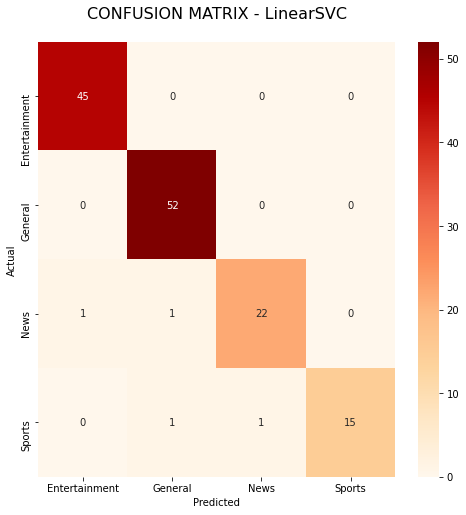

In [13]:
conf_mat = confusion_matrix(y_test, predicted,labels=[0,1,2,3])
fig, ax = plt.subplots(figsize=(8,8))
sns.heatmap(conf_mat, annot=True, cmap="OrRd", fmt='d',
            xticklabels=category_id_df.Category.values, 
            yticklabels=category_id_df.Category.values)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title("CONFUSION MATRIX - LinearSVC\n", size=16);

In [14]:
for predicted in category_id_df.category_id:
    for actual in category_id_df.category_id:
        if predicted != actual and conf_mat[actual, predicted] >0:
            print("'{}' predicted as '{}' : {} examples.".format(id_to_category[actual],id_to_category[predicted],
                                                                   conf_mat[actual, predicted]))
            display(df.loc[indices_test[(y_test == actual) & (y_pred == predicted)]][['Category', 
                                                                'cleaned_data']])

'News' predicted as 'Entertainment' : 1 examples.


,Category,cleaned_data
661,News,nepal spiritual trekking annapurna base camp t...


'News' predicted as 'General' : 1 examples.


,Category,cleaned_data
721,News,bloomberg robot bloomberg detect unusual activ...


'Sports' predicted as 'General' : 1 examples.


,Category,cleaned_data
862,Sports,sport job sport News sport feature sports mana...


'Sports' predicted as 'News' : 1 examples.


,Category,cleaned_data
892,Sports,liverpool echo latest liverpool merseyside New...


In [15]:
model.fit(features, labels)

N = 4
for Category, category_id in sorted(category_to_id.items()):
  indices = np.argsort(model.coef_[category_id])
  feature_names = np.array(tfidf.get_feature_names())[indices]
  unigrams = [v for v in reversed(feature_names) if len(v.split(' ')) == 1][:N]
  bigrams = [v for v in reversed(feature_names) if len(v.split(' ')) == 2][:N]
  print("\n==> '{}':".format(Category))
  print("  * Top unigrams: %s" %(', '.join(unigrams)))
  print("  * Top bigrams: %s" %(', '.join(bigrams)))


==> 'Entertainment':
  * Top unigrams: game, chess, games, music
  * Top bigrams: order online, game play, video game, board game

==> 'General':
  * Top unigrams: care, software, grocery, student
  * Top bigrams: free shipping, grocery shopping, enable javascript, easy use

==> 'News':
  * Top unigrams: trump, news, politics, entertainment
  * Top bigrams: world news, news world, late news, breaking news

==> 'Sports':
  * Top unigrams: football, badminton, league, nfl
  * Top bigrams: premier league, real madrid, december december, champions league


In [16]:
X_train, X_test, y_train, y_test = train_test_split(X, df['category_id'], 
                                                    test_size=0.15,
                                                    random_state = 0)

tfidf = TfidfVectorizer(sublinear_tf=True, min_df=5,
                        ngram_range=(1, 2), 
                        stop_words='english')

fitted_vectorizer = tfidf.fit(X_train)
tfidf_vectorizer_vectors = fitted_vectorizer.transform(X_train)

m = LinearSVC().fit(tfidf_vectorizer_vectors, y_train)
m1=CalibratedClassifierCV(base_estimator=m,
                                        cv="prefit").fit(tfidf_vectorizer_vectors, y_train)

In [17]:
from bs4 import BeautifulSoup
import bs4 as bs4
from urllib.parse import urlparse
import requests
from collections import Counter
import pandas as pd
import os
class ScrapTool:
    def visit_url(self, website_url):
        content = requests.get(website_url,timeout=60).content
        
        soup = BeautifulSoup(content, "lxml")
        result = {
            "website_url": website_url,
            "website_name": self.get_website_name(website_url),
            "website_text": self.get_html_title_tag(soup)+self.get_html_meta_tags(soup)+self.get_html_heading_tags(soup)+
                                                               self.get_text_content(soup)
        }
        
        return pd.Series(result)
    
    def get_website_name(self,website_url):
        return "".join(urlparse(website_url).netloc.split(".")[-2])
    
    def get_html_title_tag(self,soup):
        return '. '.join(soup.title.contents)
    
    def get_html_meta_tags(self,soup):
        tags = soup.find_all(lambda tag: (tag.name=="meta") & (tag.has_attr('name') & (tag.has_attr('content'))))
        content = [str(tag["content"]) for tag in tags if tag["name"] in ['keywords','description']]
        return ' '.join(content)
    
    def get_html_heading_tags(self,soup):
        tags = soup.find_all(["h1","h2","h3","h4","h5","h6"])
        content = [" ".join(tag.stripped_strings) for tag in tags]
        return ' '.join(content)
    
    def get_text_content(self,soup):
        tags_to_ignore = ['style', 'script', 'head', 'title', 'meta', '[document]',"h1","h2","h3","h4","h5","h6","noscript"]
        tags = soup.find_all(text=True)
        result = []
        for tag in tags:
            stripped_tag = tag.strip()
            if tag.parent.name not in tags_to_ignore\
                and isinstance(tag, bs4.element.Comment)==False\
                and not stripped_tag.isnumeric()\
                and len(stripped_tag)>0:
                result.append(stripped_tag)
        return ' '.join(result)
import spacy as sp
from collections import Counter
sp.prefer_gpu()
nlp = sp.load('en_core_web_sm')
import re
def clean_text(doc):
    doc = nlp(doc)
    tokens = []
    exclusion_list = ["nan"]
    for token in doc:
        if token.is_stop or token.is_punct or token.text.isnumeric() or (token.text.isalnum()==False) or token.text in exclusion_list :
            continue
        token = str(token.lemma_.lower().strip())
        tokens.append(token)
    return " ".join(tokens)

C:\Users\RIDHIMAN\Documents\New folder\lib\site-packages\spacy\util.py:877: UserWarning: [W095] Model 'en_core_web_sm' (3.0.0) was trained with spaCy v3.0 and may not be 100% compatible with the current version (3.4.3). If you see errors or degraded performance, download a newer compatible model or retrain your custom model with the current spaCy version. For more details and available updates, run: python -m spacy validate
  warnings.warn(warn_msg)


In [18]:
dataframe = pd.read_csv('C:/Users/RIDHIMAN/Desktop/dish_dataset_gen.csv')
dataframe.shape
df = dataframe[['website']].copy()
df = df.dropna()
lst = []
for i in range(0,dataframe.shape[0]):
  lst.append(dataframe.website.values[i])

In [ ]:
while True:
  try:
    for i in lst:
      website = i
      scrapTool = ScrapTool()
      web=dict(scrapTool.visit_url(website))
      text=(clean_text(web['website_text']))
      t=fitted_vectorizer.transform([text])
      print(website, id_to_category[m1.predict(t)[0]])
    
  except:
    print(i+"\n\n\n\n\n")
    lst.remove(i)
  else:
    break

http://www.msn.com News
http://www.netflix.com/ Entertainment
http://www.cnn.com News
http://www.foxnews.com News
http://quizlet.com General
http://groupon.com General
http://www.nexusmods.com Entertainment
http://www.usatoday.com News
http://www.spotify.com Entertainment
http://www.quordle.com Entertainment
http://celebwell.com General
http://www.kohls.com General
http://www.asurascans.com Entertainment
http://www.si.com Sports
http://ml.t-mobile.com General
http://www.chess.com Entertainment
http://prosportstrivia.com Sports
http://mytravelquiz.com Entertainment
http://www.chegg.com Entertainment
http://pagesix.com News
http://www.foxbusiness.com News
http://thespun.com Sports
http://youreverydayentertainment.com News
http://www.baseball-reference.com Sports
http://www.realtor.com General
http://www.theverge.com News
http://bestlifeonline.com General
http://traderie.com General
http://www.freep.com News
http://wheelofnames.com General
http://www.washingtonpost.com News
http://9gag.co

http://www.spanishdict.com General
http://www.foxnews.com News
http://www.monstersandcritics.com News
http://www.accuweather.com News
http://www.wral.com News
http://aviewfrommyseat.com General
http://letterboxd.com Entertainment
http://celebwell.com General
http://awoiaf.westeros.org General
http://zone.msn.com Entertainment
http://www.buzzfeed.com Entertainment
http://www.pricecharting.com Entertainment
http://www.ontvtonight.com Entertainment
http://www.lightnovelpub.com General
http://www.affordablehousing.com Entertainment
http://games.usatoday.com Entertainment
http://www.thingiverse.com General
http://www.royalroad.com Entertainment
http://ecogetaway.com Entertainment
http://www.engagementsphotos.com General
http://game8.co Entertainment
http://www.thestreet.com News
http://www.missyusa.com General
http://fortnitetracker.com Sports
http://thehill.com News
http://www.pixilart.com General
http://www.on3.com Sports
http://www.boredpanda.com General
http://pethelpful.com General
htt

http://quizlet.com General
http://groupon.com General
http://www.nexusmods.com Entertainment
http://www.usatoday.com News
http://www.spotify.com Entertainment
http://www.quordle.com Entertainment
http://celebwell.com General
http://www.kohls.com General
http://www.asurascans.com Entertainment
http://www.si.com Sports
http://ml.t-mobile.com General
http://www.chess.com Entertainment
http://prosportstrivia.com Sports
http://mytravelquiz.com Entertainment
http://www.chegg.com Entertainment
http://pagesix.com News
http://www.foxbusiness.com News
http://thespun.com Sports
http://youreverydayentertainment.com News
http://www.baseball-reference.com Sports
http://www.realtor.com General
http://www.theverge.com News
http://bestlifeonline.com General
http://traderie.com General
http://www.freep.com News
http://wheelofnames.com General
http://www.washingtonpost.com News
http://9gag.com News
http://www.fflogs.com Entertainment
http://webmd.com General
http://people.com News
http://www.espn.com Spo